In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [3]:
spotify_df = pd.read_csv('data/data.csv')
spotify_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

In [4]:
data_w_genre = pd.read_csv('data/data_w_genres.csv')
data_w_genre.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

In [5]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [6]:
data_w_genre['genres'].values[0]


"['show tunes']"

 it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [7]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [8]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [9]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [10]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

valence  year  acousticness                             artists  \
143    0.300  1921         0.772                ["Scarlet D'Carpio"]   
234    0.902  1923         0.994  ["King Oliver's Creole Jazz Band"]   
238    0.554  1923         0.996  ["King Oliver's Creole Jazz Band"]   
244    0.319  1923         0.995    ["Clarence Williams' Blue Five"]   
249    0.753  1923         0.994  ["King Oliver's Creole Jazz Band"]   

     danceability  duration_ms  energy  explicit                      id  \
143         0.560       249370   0.313         0  7b4eHImKQ51DYaQvNTdtEp   
234         0.708       194533   0.361         0  1xEEYhWxT4WhDQdxfPCT8D   
238         0.546       170827   0.189         0  3rauXVLOOM5BlxWqUcDpkg   
244         0.520       197493   0.153         0  1UdqHVRFYMZKU2Q7xkLtYc   
249         0.359       187227   0.357         0  5SvyP1ZeJX1jA7AOZD08NA   

     instrumentalness  key  liveness  loudness  mode                     name  \
143          0.000005    6     0.115    -8.346     0  Himno Nacional del Perú   
234          0.883000    0     0.103   -11.764     0                Snake Rag   
238          0.908000    0     0.339   -15.984     1             Chimes Blues   
244          0.131000    0     0.353   -14.042     1     Pickin' On Your Baby   
249          0.819000    3     0.290   -11.810     1                    Tears   

     popularity release_date  speechiness    tempo artists_upd_v1  
143           0   1921-09-23       0.0376  107.501             []  
234          20         1923       0.0441  105.695             []  
238          13         1923       0.0581   80.318             []  
244          11         1923       0.0440  102.937             []  
249          10         1923       0.0511  205.053             []

In [11]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [12]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [13]:
spotify_df[spotify_df['name']=='Adore You']

valence  year  acousticness           artists  danceability  \
19425    0.569  2019        0.0237  ['Harry Styles']         0.676   
38319    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id  \
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7   
38319       207133   0.771         0  1M4qEo4HE3PRaCOM7EXNJq   

       instrumentalness  ...  mode       name  popularity  release_date  \
19425          0.000007  ...     1  Adore You          88    2019-12-13   
38319          0.000007  ...     1  Adore You          77    2019-12-06   

      speechiness   tempo  artists_upd_v1  artists_upd_v2     artists_upd  \
19425      0.0483  99.048  [Harry Styles]              []  [Harry Styles]   
38319      0.0483  99.048  [Harry Styles]              []  [Harry Styles]   

                artists_song  
19425  Harry StylesAdore You  
38319  Harry StylesAdore You  

[2 rows x 23 columns]

In [14]:
spotify_df.drop_duplicates('artists_song',inplace = True)


In [15]:
spotify_df[spotify_df['name']=='Adore You']


valence  year  acousticness           artists  danceability  \
19425    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id  \
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7   

       instrumentalness  ...  mode       name  popularity  release_date  \
19425          0.000007  ...     1  Adore You          88    2019-12-13   

      speechiness   tempo  artists_upd_v1  artists_upd_v2     artists_upd  \
19425      0.0483  99.048  [Harry Styles]              []  [Harry Styles]   

                artists_song  
19425  Harry StylesAdore You  

[1 rows x 23 columns]

In [16]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [17]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [18]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']


Empty DataFrame
Columns: [artists_upd, id, genres, artists, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence, popularity, key, mode, count, genres_upd]
Index: []

In [19]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...   
1  000GyYHG4uWmlXieKLij8u  [[alternative_hip_hop, conscious_hip_hop, minn...   
2  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
3  000ZxLGm7jDlWCHtcXSeBe    [[boogie-woogie, piano_blues, ragtime, stride]]   
4  000jBcNljWTnyjB4YO7ojf                                               [[]]   

                            consolidates_genre_lists  
0  [power_pop, rock, permanent_wave, dance_rock, ...  
1  [pop_rap, alternative_hip_hop, conscious_hip_h...  
2  [classic_bollywood, ghazal, filmi, sufi, class...  
3      [piano_blues, ragtime, stride, boogie-woogie]  
4                                                 []

In [20]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

Feature Engineering
- Normalize float variables
- OHE Year and Popularity Variables
- Create TF-IDF features off of artist genres

In [21]:
spotify_df.tail()


valence  year  acousticness  \
156602    0.768  1997        0.2820   
156603    0.792  2004        0.0248   
156604    0.697  1999        0.0516   
156605    0.429  1994        0.0249   
156606    0.273  1996        0.0113   

                                               artists  danceability  \
156602                      ["Lil' Kim", "Lil' Cease"]         0.748   
156603                            ["Lil' Flip", 'Lea']         0.814   
156604  ["Ol' Dirty Bastard", 'Kelis', 'Rich Travali']         0.934   
156605      ["World Class Wreckin' Cru", "Michel 'Le"]         0.715   
156606      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']         0.897   

        duration_ms  energy  explicit                      id  \
156602       275947   0.693         0  2LP2uDQQ7eLMcUVE4aOpAV   
156603       225173   0.387         1  4s0o8TJHfX9LLHa0umnOzT   
156604       239547   0.459         1  6YYd5MLpu45J0uLrMdivF7   
156605       351040   0.490         0  3hoiinUc5VA9xUEJID7R8V   
156606       337973   0.414         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  ...                                     name  \
156602           0.00000  ...  Crush on You (feat. Lil' Cease) - Remix   
156603           0.00000  ...                     Sunshine (feat. Lea)   
156604           0.00000  ...             Got Your Money (feat. Kelis)   
156605           0.00017  ...                Turn Off The Lights - Rap   
156606           0.00011  ...                          Never Talk Down   

        popularity  release_date  speechiness    tempo  \
156602          56    1997-06-30       0.2780   88.802   
156603          62    2004-03-30       0.0945   93.961   
156604          66          1999       0.1890  103.040   
156605          36    1994-04-06       0.0479  129.309   
156606          35          1996       0.2460   96.039   

                 artists_upd_v1                          artists_upd_v2  \
156602            [ Kim", "Lil]                  [Lil' Kim, Lil' Cease]   
156603               [ Flip", ]                             [Lil' Flip]   
156604  [ Dirty Bastard", , , ]                     [Ol' Dirty Bastard]   
156605        [ Cru", "Michel ]  [World Class Wreckin' Cru, Michel 'Le]   
156606          [ 4-Tay", , , ]                         [Rappin' 4-Tay]   

                    artists_upd  \
156602            [ Kim", "Lil]   
156603               [ Flip", ]   
156604  [ Dirty Bastard", , , ]   
156605        [ Cru", "Michel ]   
156606          [ 4-Tay", , , ]   

                                             artists_song  \
156602   Kim", "LilCrush on You (feat. Lil' Cease) - R...   
156603                        Flip", Sunshine (feat. Lea)   
156604       Dirty Bastard", Got Your Money (feat. Kelis)   
156605            Cru", "Michel Turn Off The Lights - Rap   
156606                            4-Tay", Never Talk Down   

       consolidates_genre_lists  
156602                      NaN  
156603                      NaN  
156604                      NaN  
156605                      NaN  
156606                      NaN  

[5 rows x 24 columns]

In [22]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values
ohe_cols = 'popularity'
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [23]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [24]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])
spotify_df.head()

valence  year  acousticness         artists  danceability  duration_ms  \
0    0.177  1989         0.568         ['조정현']         0.447       237688   
1    0.352  1992         0.381          ['黑豹']         0.353       316160   
2    0.458  1963         0.987         ['黃國隆']         0.241       193480   
3    0.796  1963         0.852  ['黃國隆', '王秋玉']         0.711       145720   
4    0.704  1963         0.771         ['黃國隆']         0.610       208760   

   energy  explicit                      id  instrumentalness  ...  \
0  0.2150         0  2ghebdwe2pNXT4eL34T7pW          0.000001  ...   
1  0.6860         0  3KIuCzckjdeeVuswPo20mC          0.000000  ...   
2  0.0437         0  4prhqrLXYMjHJ6vpRAlasx          0.000453  ...   
3  0.1110         0  5xFXTvnEe03SyvFpo6pEaE          0.000000  ...   
4  0.1750         0  6Pqs2suXEqCGx7Lxg5dlrB          0.000000  ...   

   popularity  release_date  speechiness    tempo artists_upd_v1  \
0          31    1989-06-15       0.0272   71.979          [조정현]   
1          35    1992-12-22       0.0395  200.341           [黑豹]   
2          23    1963-05-28       0.0443   85.936          [黃國隆]   
3          23    1963-05-28       0.0697  124.273     [黃國隆, 王秋玉]   
4          23    1963-05-28       0.0419  124.662          [黃國隆]   

   artists_upd_v2 artists_upd            artists_song  \
0              []       [조정현]           조정현그아픔까지사랑한거야   
1              []        [黑豹]  黑豹DON'T BREAK MY HEART   
2              []       [黃國隆]                  黃國隆藝旦調   
3              []  [黃國隆, 王秋玉]                黃國隆草螟弄雞公   
4              []       [黃國隆]                  黃國隆思想起   

              consolidates_genre_lists popularity_red  
0                 [classic_korean_pop]              6  
1  [chinese_indie, chinese_indie_rock]              7  
2                                   []              4  
3                                   []              4  
4                                   []              4  

[5 rows x 25 columns]

In [25]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [26]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [27]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)


In [28]:
complete_feature_set.head()


genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   ...  year|2012  year|2013  year|2014  year|2015  year|2016  year|2017  \
0  ...        0.0        0.0        0.0        0.0        0.0        0.0   
1  ...        0.0        0.0        0.0        0.0        0.0        0.0   
2  ...        0.0        0.0        0.0        0.0        0.0        0.0   
3  ...        0.0        0.0        0.0        0.0        0.0        0.0   
4  ...        0.0        0.0        0.0        0.0        0.0        0.0   

   year|2018  year|2019  year|2020                      id  
0        0.0        0.0        0.0  2ghebdwe2pNXT4eL34T7pW  
1        0.0        0.0        0.0  3KIuCzckjdeeVuswPo20mC  
2        0.0        0.0        0.0  4prhqrLXYMjHJ6vpRAlasx  
3        0.0        0.0        0.0  5xFXTvnEe03SyvFpo6pEaE  
4        0.0        0.0        0.0  6Pqs2suXEqCGx7Lxg5dlrB  

[5 rows x 3071 columns]

In [29]:
#client id and secret for my application
client_id = '941e4cf6c2294d018f5dde685dbc5e0c'
client_secret= '6f2b6dbaffdb4ba8ae4ea06b8d40c45d'

In [30]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
    print(sys.argv)
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

['C:\\Users\\irem.calmaz\\Anaconda3\\envs\\RecSys\\lib\\site-packages\\ipykernel_launcher.py', '--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"2dc78d16-073a-4fe2-a0fd-6d1ea1b34aa1"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=C:\\Users\\IREM~1.CAL\\AppData\\Local\\Temp\\tmp-28196k3utZQRQM0Le.json']


In [31]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [32]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')


In [33]:
sp = spotipy.Spotify(auth=token)


In [34]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
links={}
for i in sp.current_user_playlists()['items']:
    links=i['external_urls']['spotify'].split("/playlist/")[1]
    id_name[links] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [35]:
list_photo


{'7oMa65813CFG9Fp5lj5ahR': 'https://i.scdn.co/image/ab67706c0000bebb423b737c5856c6f8086e2b81',
 '034Z9Os08xpwFZ4IBiXqdH': 'https://i.scdn.co/image/ab67706c0000bebb340692a4cb237121f0c7540d',
 '6FEhDsOPySsfzLkMVYvOmY': 'https://mosaic.scdn.co/640/ab67616d0000b273073aebff28f79959d2543596ab67616d0000b2734ad6e5838f15401ff7d62856ab67616d0000b2735b7865be7f7fcc05faec6137ab67616d0000b273c1ea4aac1ad07a38c59dd30c',
 '5w4yzHEaahMMripDuHKf30': 'https://i.scdn.co/image/ab67706c0000bebb0a0b92e13c2d378ba0b9f388',
 '3vd7QQBcDXnogrFfmDALKw': 'https://mosaic.scdn.co/640/ab67616d0000b2734cc760a4b2474f8e2284910aab67616d0000b2734eab8ed2ae98baa7a7796405ab67616d0000b27377d779b4b33fa11add0570ebab67616d0000b2738bf8038f7f9584aec9f7d180',
 '0o92KA0rmQpbZI5PQNenpm': 'https://i.scdn.co/image/ab67706c0000bebb2e23f9a37475a17768f3e32c',
 '24DZiKfJZiMAgYMYEifDu0': 'https://mosaic.scdn.co/640/ab67616d0000b2734b292ed7c7360a04d3d6b74aab67616d0000b273707d13d3f87652e737e94d45ab67616d0000b27393bc52fe298b498ed5a806a4ab67616d0

In [36]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name
    for ix, i in enumerate(sp.playlist("7oMa65813CFG9Fp5lj5ahR")['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [37]:
id_name


{'7oMa65813CFG9Fp5lj5ahR': '7oMa65813CFG9Fp5lj5ahR',
 '034Z9Os08xpwFZ4IBiXqdH': '034Z9Os08xpwFZ4IBiXqdH',
 '6FEhDsOPySsfzLkMVYvOmY': '6FEhDsOPySsfzLkMVYvOmY',
 '5w4yzHEaahMMripDuHKf30': '5w4yzHEaahMMripDuHKf30',
 '3vd7QQBcDXnogrFfmDALKw': '3vd7QQBcDXnogrFfmDALKw',
 '0o92KA0rmQpbZI5PQNenpm': '0o92KA0rmQpbZI5PQNenpm',
 '24DZiKfJZiMAgYMYEifDu0': '24DZiKfJZiMAgYMYEifDu0',
 '1XGMb5HeRXhmRXfFLVzHcx': '1XGMb5HeRXhmRXfFLVzHcx',
 '66nVGDQIqoukk5W4MRwtHy': '66nVGDQIqoukk5W4MRwtHy',
 '5YwSQdFxHMDdFWYoA8qeRL': '5YwSQdFxHMDdFWYoA8qeRL'}

In [38]:
playlist_Aqua = create_necessary_outputs('https://open.spotify.com/playlist/7oMa65813CFG9Fp5lj5ahR', id_name,spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [39]:
from  skimage import io

import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [40]:
playlist_Aqua

artist                        name                      id  \
51             TV Girl                 Lovers Rock  1H7zdcRD0gLGQY0w5ejGgX   
46          The Marías                      Cariño  55DyBUkjebkcYhDGfEXitR   
43               Jakob                Velvet Light  41o2ydrj7Xm9Yt5odIBqq4   
37               Jakob       You Might Be Sleeping  2KvbRojbZGMsWr1Nuj5n2f   
36  Tyler, The Creator                  Peach Fuzz  0F58GE2TtHBim5o4ZTQUwK   
34              WILLOW       Female Energy, Part 2  0W95eMaAxNVYTquOsXXkC5   
31          Kali Uchis                     Melting  2kSb3wYSOV996xA2NSmpck   
28             Monsune               OUTTA MY MIND  7zTTDkkLkJ2iHAqq1daDCr   
27  Tyler, The Creator       ARE WE STILL FRIENDS?  5TxRUOsGeWeRl3xOML59Ai   
26          Mac Miller                Small Worlds  4gT3mNJA8lnlkYFqGZ8IA2   
25         Men I Trust                 Show Me How  01TyFEZu6mHbffsVfxgrFn   
24              WILLOW                Time Machine  1jVjOcs7QeQZJXScbqvofI   
22          Steve Lacy                        Some  4riDfclV7kPDT9D58FpmHd   
21          Steve Lacy                      N Side  24G1PXBWoRgV0wDXZKwxzz   
20                 Djo                       Roddy  20WSCvv9qfQHzYzTaLyXHH   
18        Dominic Fike                    Babydoll  7yNf9YjeO5JXUE3JEBgnYc   
17             Dr. Dog    Where'd All the Time Go?  0UV5zxRMz6AO4ZwUOZNIKI   
16          Surf Curse                       Disco  644hazYIWNQq4URUn7CPnQ   
15         Mac DeMarco       Chamber Of Reflection  1MJ5f5EYBC92ADD6xcz7nb   
13          Los Retros  Someone To Spend Time With  0qQ9VcVPkWDTnff6HIhISU   
12   The Neighbourhood            Cherry Flavoured  40iocOzytrqaRn5RbGPDNp   
9           Thundercat                Them Changes  7CH99b2i1TXS5P8UUyWtnM   
2           Steve Lacy                         Ryd  3I8yVFjvJoOBM9tX4ZpxEL   
1           Steve Lacy                    C U Girl  6FBzhcfgGacfXF3AmtfEaX   
0           Steve Lacy                    Dark Red  37y7iDayfwm3WXn5BiAoRk   

                                                  url  \
51  https://i.scdn.co/image/ab67616d00001e023cfca7...   
46  https://i.scdn.co/image/ab67616d00001e024b6193...   
43  https://i.scdn.co/image/ab67616d00001e02fd0095...   
37  https://i.scdn.co/image/ab67616d00001e02987356...   
36  https://i.scdn.co/image/ab67616d00001e02819163...   
34  https://i.scdn.co/image/ab67616d00001e023e0c22...   
31  https://i.scdn.co/image/ab67616d00001e02dbc47f...   
28  https://i.scdn.co/image/ab67616d00001e02b30910...   
27  https://i.scdn.co/image/ab67616d00001e02700588...   
26  https://i.scdn.co/image/ab67616d00001e02175c57...   
25  https://i.scdn.co/image/ab67616d00001e0240faef...   
24  https://i.scdn.co/image/ab67616d00001e023e0c22...   
22  https://i.scdn.co/image/ab67616d00001e027c0c6c...   
21  https://i.scdn.co/image/ab67616d00001e029b7915...   
20  https://i.scdn.co/image/ab67616d00001e021d65b1...   
18  https://i.scdn.co/image/ab67616d00001e027b1b6f...   
17  https://i.scdn.co/image/ab67616d00001e02047806...   
16  https://i.scdn.co/image/ab67616d00001e02c03cf7...   
15  https://i.scdn.co/image/ab67616d00001e027da53b...   
13  https://i.scdn.co/image/ab67616d00001e0202a532...   
12  https://i.scdn.co/image/ab67616d00001e021a721f...   
9   https://i.scdn.co/image/ab67616d00001e0285c5e6...   
2   https://i.scdn.co/image/ab67616d00001e02a31dd5...   
1   https://i.scdn.co/image/ab67616d00001e02447d52...   
0   https://i.scdn.co/image/ab67616d00001e02263886...   

                  date_added  
51 2022-01-25 16:55:28+00:00  
46 2021-09-11 22:28:09+00:00  
43 2021-09-11 22:26:42+00:00  
37 2021-08-10 14:44:13+00:00  
36 2021-08-10 14:43:55+00:00  
34 2021-08-10 14:43:12+00:00  
31 2021-08-05 04:59:14+00:00  
28 2021-07-25 18:11:53+00:00  
27 2021-07-25 18:11:39+00:00  
26 2021-07-25 18:11:32+00:00  
25 2021-07-25 18:11:12+00:00  
24 2021-07-25 18:11:09+00:00  
22 2021-07-25 18:10:19+00:00  
21 2021-07-25 18:10:09+00:00  
20 2021-07-25 18:08:06+00:00  
18 2021-

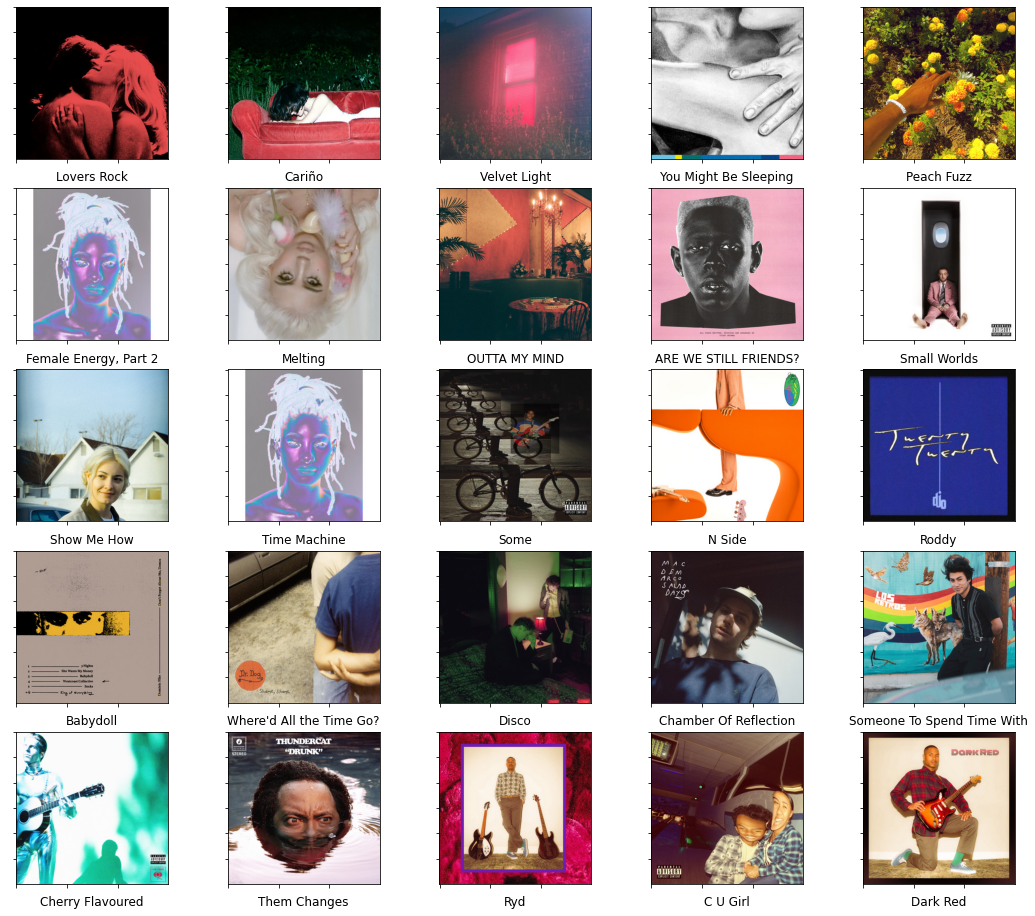

In [41]:
visualize_songs(playlist_Aqua)


In [42]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [43]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_Aqua, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [44]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [45]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)


In [46]:
edm_top40


valence  year  acousticness  \
81630    0.6410  2018       0.12700   
80062    0.4210  2019       0.68300   
92869    0.2890  2019       0.13500   
31262    0.4540  1958       0.78500   
123299   0.5920  2019       0.35100   
50801    0.8140  2019       0.02090   
39022    0.1580  2019       0.58500   
46228    0.5560  2019       0.50500   
79931    0.6690  2019       0.00103   
46225    0.4800  2019       0.18900   
50800    0.4210  2019       0.61700   
46227    0.2040  2019       0.54700   
33464    0.6740  2019       0.39700   
8045     0.6650  2019       0.05360   
117556   0.5870  2019       0.00666   
155391   0.3040  2018       0.44300   
100031   0.3400  2018       0.17900   
5687     0.8490  2018       0.87600   
12368    0.2970  2017       0.04560   
29869    0.6070  2019       0.20100   
100042   0.1720  2019       0.08180   
8040     0.3650  2019       0.05740   
92103    0.6970  2018       0.13200   
79939    0.3710  2018       0.63500   
33469    0.4560  2019       0.10100   
115683   0.2280  2019       0.87200   
79942    0.4970  2018       0.09820   
108900   0.2980  2019       0.51800   
32761    0.2670  2019       0.34100   
79930    0.2070  2018       0.55200   
79932    0.1930  2018       0.69400   
102194   0.3970  2017       0.10600   
10       0.7970  2019       0.02810   
79940    0.5560  2019       0.09330   
33470    0.0631  2019       0.02270   
79948    0.5690  2017       0.64300   
12335    0.4640  2019       0.09670   
84423    0.6400  2019       0.11600   
12341    0.5840  2019       0.35200   
92741    0.4910  2017       0.29300   

                                                  artists  danceability  \
81630                        ['Kali Uchis', 'Steve Lacy']         0.745   
80062                                  ['Kevin Abstract']         0.646   
92869                                 ['Jaden', 'WILLOW']         0.569   
31262                                      ['Steve Lacy']         0.492   
123299                              ['Doja Cat', 'Smino']         0.807   
50801                              ['Peach Tree Rascals']         0.870   
39022                                 ['Sabrina Claudio']         0.645   
46228                                      ['ROLE MODEL']         0.791   
79931                                          ['Khalid']         0.665   
46225                                      ['ROLE MODEL']         0.778   
50800                              ['Peach Tree Rascals']         0.676   
46227                                      ['ROLE MODEL']         0.575   
33464                                         ['Solange']         0.823   
8045                                       ['Will Smith']         0.688   
117556                              ['Emotional Oranges']         0.696   
155391                        ['A$AP Rocky', 'FKA twigs']         0.798   
100031                                         ['H.E.R.']         0.614   
5687                                             ['Yeek']         0.717   
12368   ['Tyler, The Creator', 'Frank Ocean', 'Steve L...         0.480   
29869                          ['Summer Walker', '6LACK']         0.707   
100042                                         ['H.E.R.']         0.444   
8040                                       ['Will Smith']         0.409   
92103                                   ['Janelle Monáe']         0.859   
79939                                          ['Khalid']         0.540   
33469                                         ['Solange']         0.863   
115683                                      ['FKA twigs']         0.563   
79942                                          ['Khalid']         0.554   
108900     ['Free Nationals', 'Mac Miller', 'Kali Uchis']         0.469   
32761                                       ['Souly Had']         0.756   
79930                                          ['Khalid']         0.487   
79932                                ['Khalid', 'H.E.R.']         0.620   
102194  

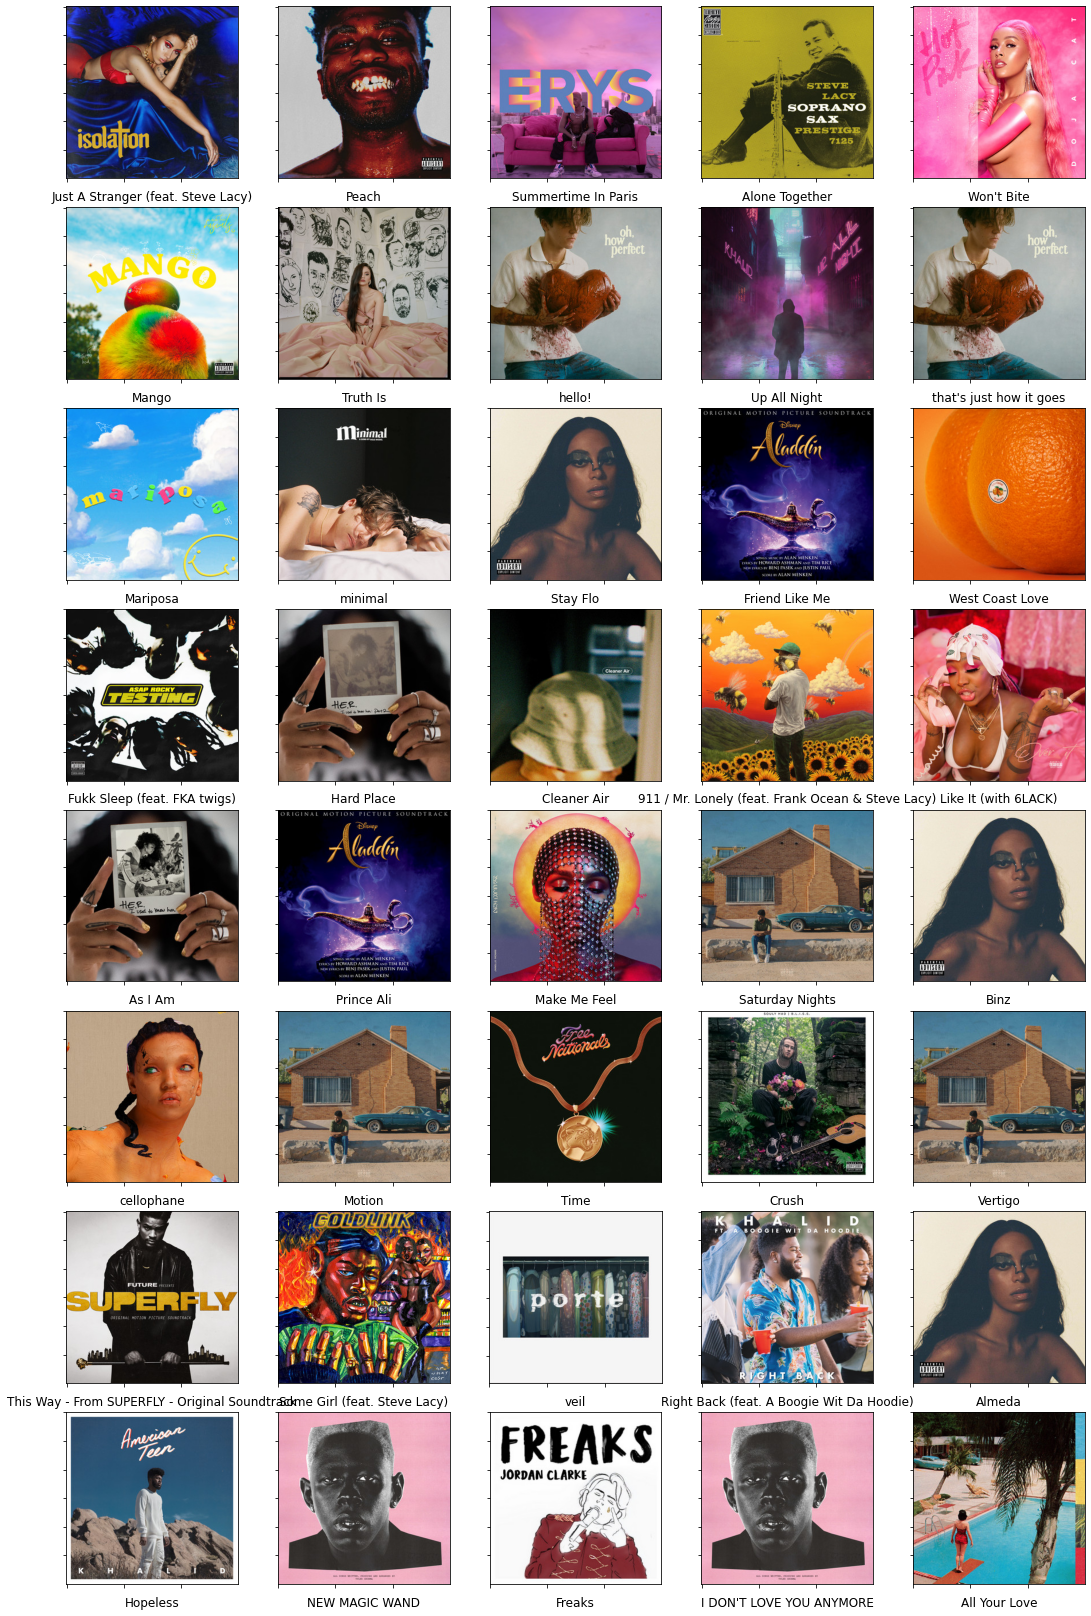

In [47]:
visualize_songs(edm_top40)


In [15]:
import re
playlist_name="https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M?si=1f1a7fb80ebd451e"
playlist_name = playlist_name.split('?')[0]

playlist_name = playlist_name.split('/')[4]


print(playlist_name)

37i9dQZF1DXcBWIGoYBM5M?si
